### scene 분류

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_dir='c:/workspace3/data/images/intel-image-classification/seg_train/seg_train'
test_dir='c:/workspace3/data/images/intel-image-classification/seg_test/seg_test'

train_data_gen=ImageDataGenerator(rescale = 1/255.)
test_data_gen=ImageDataGenerator(rescale=1/255.)

train_data = train_data_gen.flow_from_directory(train_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

val_data = test_data_gen.flow_from_directory(test_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
images, labels = train_data.next()
#                           batch size 데이터 공급
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [5]:
images1, labels1 = val_data.next()
len(images1), len(labels1), images1[0].shape

(32, 32, (224, 224, 3))

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential, Input

import tensorflow as tf
with tf.device('/:GPU0'):
    model = Sequential([
                Input(shape = images[0].shape),
                Conv2D(32, (3, 3), padding='same', activation='relu'),
                MaxPooling2D((2, 2), strides=2),
                Conv2D(64, (3, 3), padding='same', activation='relu'),
                MaxPooling2D((2, 2), strides=2),
                Flatten(),
                Dense(128, activation = 'relu'),
                Dense(6, activation = 'softmax'),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [9]:
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
with tf.device('/:GPU0'):
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1,
                                  factor = 0.5, min_lr = 0.00001)

    classifier=model.fit(train_data,
                            validation_data=val_data,
                            batch_size=64,
                            verbose=1,
                            epochs=2,
                            callbacks=[reduce_lr])

Epoch 1/2
439/439 [==============================] - 516s 1s/step - loss: 1.1001 - accuracy: 0.6243 - val_loss: 0.7933 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 2/2
439/439 [==============================] - 561s 1s/step - loss: 0.6001 - accuracy: 0.7839 - val_loss: 0.6815 - val_accuracy: 0.7557 - lr: 0.0010


In [12]:
import tensorflow as tf
with tf.device('/:GPU0'):
    model.evaluate(val_data)

94/94 [==============================] - 22s 234ms/step - loss: 0.6815 - accuracy: 0.7557


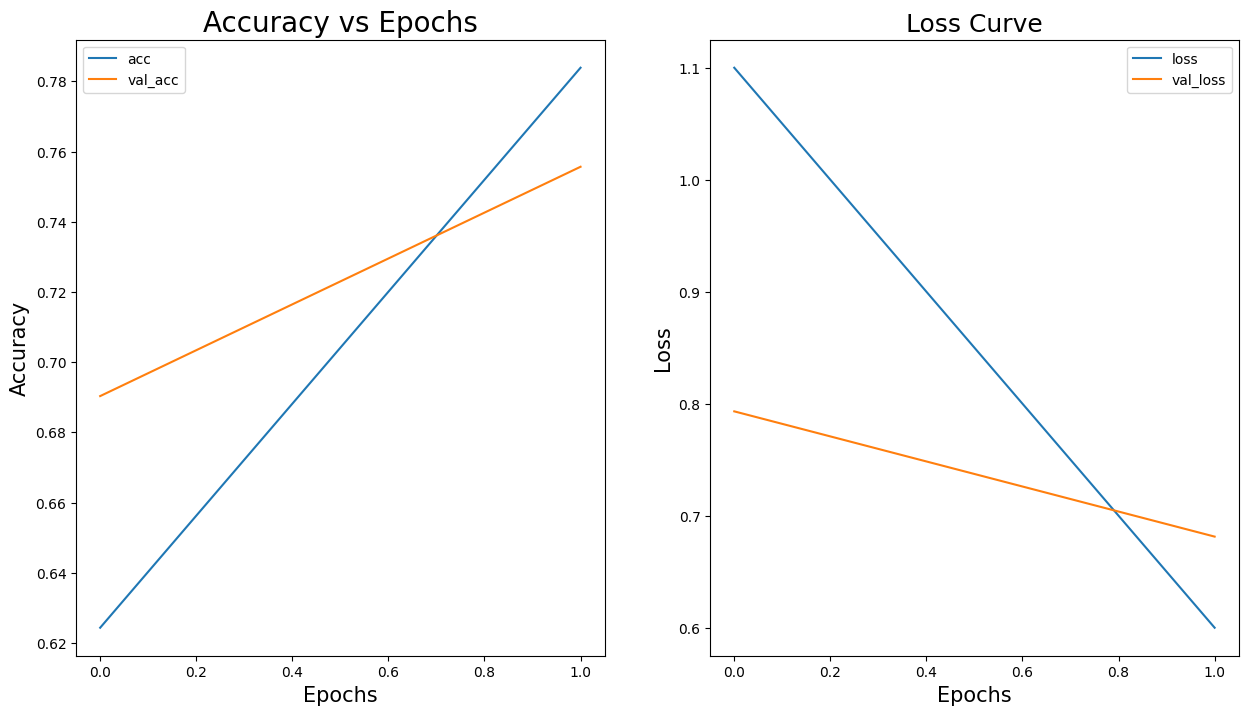

In [13]:
def model_performance_graphs():
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')

    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)

    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)

    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")

    axes[1].set_title("Loss Curve",fontsize=18)

    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)

    axes[1].legend()

    plt.show()   

model_performance_graphs()

In [15]:
import tensorflow as tf
with tf.device('/:GPU0'):
    model.save('scene_model.h5')

In [17]:
from tensorflow.keras.models import load_model
import tensorflow as tf
with tf.device('/:GPU0'):
    loaded_model = load_model('scene_model.h5')

In [18]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))
#                        경로           사이즈
    img_array = image.img_to_array(img)
#                   이미지 => 넘파이 배열
    img_array = np.expand_dims(img_array, axis=0)
#                   자원 증가
    img_preprocessed = img_array / 255.0  

    return img_preprocessed

In [19]:
import tensorflow as tf
with tf.device('/:GPU0'):
    img_path = "c:/workspace3/data/images/intel-image-classification/seg_test/seg_test/mountain/20327.jpg"

    img = preprocess_images(img_path)

    prediction = loaded_model.predict(img)
    predicted_class_index = np.argmax(prediction)

    class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    predicted_class_label = class_labels[predicted_class_index]

    print("Predicted class:", predicted_class_label)

1/1 [==============================] - 0s 124ms/step
Predicted class: mountain
